# Zindi Landslide Prevention and Innovation Challenge

In [1]:
import lightgbm as lgb
if not lgb.__version__ =='3.3.2':
  print('You must install LightGBM 3.3.2')
  !pip install lightgbm==3.3.2 --install-option=--gpu

In [2]:
#Import libraries

import pandas as pd
import numpy as np
import random
import itertools
from functools import partial
import os
import sys
import gc

import sklearn
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import f1_score, make_scorer

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, classification_report,confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

## Versions

In [3]:
def print_ver(m):
  print(f' {m.__name__} version: {m.__version__}')  
print_ver(np)
print_ver(pd)
print_ver(lgb)
print_ver(sklearn)

 numpy version: 1.21.6
 pandas version: 1.3.5
 lightgbm version: 3.3.2
 sklearn version: 1.0.2


## Load Data

In [4]:
#from google.colab import drive
#drive.mount('/content/drive')

In [5]:
# read data from https://zindi.africa/competitions/landslide-prevention-and-innovation-challenge/data
# please locate data according to your current setup
path = '/content/drive/MyDrive/ColabNotebooks/Zindi_LPI/'
path="../input/start-hack-22/"
train = pd.read_csv(path+'Train.csv', index_col=0)
test = pd.read_csv(path+'Test.csv')
sample_submission = pd.read_csv(path+'SampleSubmission.csv')
y_train=train['Label'].values

# Explorary Data Analysis 

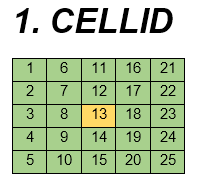


Each sample is composed of data from 25 cells, covering an area of 625 m2. Each cell represents an area of 5 x 5 m2 and has nine features (as introduced in section 2). For a landslide sample, cell 13 is the location of landslide, and other cells are the neighboring areas. For a non-landslide sample, there is no recorded landslide occurrence within the sample area.


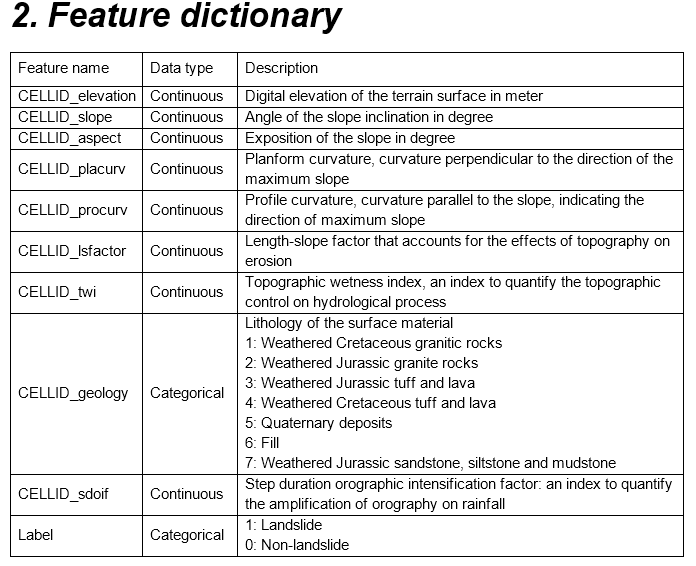

In [6]:
train.describe()

,1_elevation,2_elevation,3_elevation,4_elevation,5_elevation,6_elevation,7_elevation,8_elevation,9_elevation,10_elevation,11_elevation,12_elevation,13_elevation,14_elevation,15_elevation,16_elevation,17_elevation,18_elevation,19_elevation,20_elevation,21_elevation,22_elevation,23_elevation,24_elevation,25_elevation,1_slope,2_slope,3_slope,4_slope,5_slope,6_slope,7_slope,8_slope,9_slope,10_slope,11_slope,12_slope,13_slope,14_slope,15_slope,16_slope,17_slope,18_slope,19_slope,20_slope,21_slope,22_slope,23_slope,24_slope,25_slope,1_aspect,2_aspect,3_aspect,4_aspect,5_aspect,6_aspect,7_aspect,8_aspect,9_aspect,10_aspect,11_aspect,12_aspect,13_aspect,14_aspect,15_aspect,16_aspect,17_aspect,18_aspect,19_aspect,20_aspect,21_aspect,22_aspect,23_aspect,24_aspect,25_aspect,1_placurv,2_placurv,3_placurv,4_placurv,5_placurv,6_placurv,7_placurv,8_placurv,9_placurv,10_placurv,11_placurv,12_placurv,13_placurv,14_placurv,15_placurv,16_placurv,17_placurv,18_placurv,19_placurv,20_placurv,21_placurv,22_placurv,23_placurv,24_placurv,25_placurv,1_procurv,2_procurv,3_procurv,4_procurv,5_procurv,6_procurv,7_procurv,8_procurv,9_procurv,10_procurv,11_procurv,12_procurv,13_procurv,14_procurv,15_procurv,16_procurv,17_procurv,18_procurv,19_procurv,20_procurv,21_procurv,22_procurv,23_procurv,24_procurv,25_procurv,1_lsfactor,2_lsfactor,3_lsfactor,4_lsfactor,5_lsfactor,6_lsfactor,7_lsfactor,8_lsfactor,9_lsfactor,10_lsfactor,11_lsfactor,12_lsfactor,13_lsfactor,14_lsfactor,15_lsfactor,16_lsfactor,17_lsfactor,18_lsfactor,19_lsfactor,20_lsfactor,21_lsfactor,22_lsfactor,23_lsfactor,24_lsfactor,25_lsfactor,1_twi,2_twi,3_twi,4_twi,5_twi,6_twi,7_twi,8_twi,9_twi,10_twi,11_twi,12_twi,13_twi,14_twi,15_twi,16_twi,17_twi,18_twi,19_twi,20_twi,21_twi,22_twi,23_twi,24_twi,25_twi,1_geology,2_geology,3_geology,4_geology,5_geology,6_geology,7_geology,8_geology,9_geology,10_geology,11_geology,12_geology,13_geology,14_geology,15_geology,16_geology,17_geology,18_geology,19_geology,20_geology,21_geology,22_geology,23_geology,24_geology,25_geology,1_sdoif,2_sdoif,3_sdoif,4_sdoif,5_sdoif,6_sdoif,7_sdoif,8_sdoif,9_sdoif,10_sdoif,11_sdoif,12_sdoif,13_sdoif,14_sdoif,15_sdoif,16_sdoif,17_sdoif,18_sdoif,19_sdoif,20_sdoif,21_sdoif,22_sdoif,23_sdoif,24_sdoif,25_sdoif,Label
count,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,1

For further analysis, please refer my other notebook [here](https://www.kaggle.com/code/denizstij/eda-landslide-prevention-and-innovation/notebook)

# Feature Engineering

In [7]:
base_num_features=['elevation',  'lsfactor', 'placurv', 'procurv', 'sdoif', 'slope', 'twi', 'aspect']
base_cat_features=['geology']
for col in base_cat_features:
    cat_features=[x for x in train.columns if col in x] 

diag_lr_col_index=[[1,7,13,19,25],[2,8,14,20],[6,12,18,24]]
diag_rl_col_index=[[21,17,13,9,5],[16,12,8,4],[22,18,14,10]]
corn_col_index=[1,21,5,25]
imp_colum_index=diag_lr_col_index+diag_rl_col_index+[corn_col_index] ## import columns 
gradient_cols=['placurv', 'procurv']

In [8]:
def pre_process(df):
    res=df.copy()
    #categorical 
    for i, col in enumerate(base_cat_features):
        col_names=[x for x in df.columns if col in x]                
        col_name=f'{col}_nunique'
        
        res[col_name] = df.loc[:,col_names].nunique(axis=1)
        
        print(f'{col} new shape {res.shape}')
    
    for i in range(1,8):    
        col_name=f'geology_cat_{i}_nunique'
        mask=df.loc[:,cat_features]==i
        res[col_name]= mask.sum(axis=1)
        for ii, idx in enumerate(imp_colum_index):
            diag_col_names=[str(x)+"_geology" for x in idx ]
            col_name=f'geology_cat_{ii}_nunique_imp_idx'
            mask=df.loc[:,diag_col_names]==i
            res[col_name]= mask.sum(axis=1)            
    print(f'geology_cat_nunique new shape {res.shape}')
        
    col_name=f'geology_mode'
    res[col_name]=df.loc[:,cat_features].mode(axis=1)[0].astype('int8')
    
    print(f'geology_mode new shape {res.shape}')
    
    sum_prod_cur=None
    for i in range(1,26):
        curve_col_names=[str(i)+"_"+ x for x in gradient_cols]     
        col_name=f'curve_{i}_mean'
        res[col_name] = df.loc[:,curve_col_names].mean(axis = 1)    
        col_name=f'curve_{i}_sum'
        res[col_name] = df.loc[:,curve_col_names].sum(axis = 1)    
        col_name=f'curve_{i}_diff'
        res[col_name] = df.loc[:,curve_col_names].diff(axis = 1).iloc[:,1] 
        placurv_col_name=f'{i}_placurv'
        procurv_col_name=f'{i}_procurv'
        if sum_prod_cur is None:
            sum_prod_cur=df.loc[:,placurv_col_name]*df.loc[:,procurv_col_name]
        else:
            sum_prod_cur=sum_prod_cur+ df.loc[:,placurv_col_name]*df.loc[:,procurv_col_name]
    
    col_name=f'sum_prod_curve'
    res[col_name]=sum_prod_cur
    print(f'sum_prod_curve new shape {res.shape}')
    # numerical
    for i, col in enumerate(base_num_features):
        col_names=[x for x in df.columns if col in x]
        print(f'{col} new shape {res.shape}')
        col_name=f'{col}_mean'
        res[col_name] = df[col_names].mean(axis = 1)        
        col_name=f'{col}_std'
        res[col_name] = df[col_names].std(axis = 1)
        
        # Given that cell 13 is most important, lets look into diff and ratio
        col_name=f'13_{col}'
        d13_col_names=[f'{col}_13_sub_{i}' for i in range(25)]
        res[d13_col_names] = df.loc[:,col_names].subtract(df.loc[:,col_name], axis=0 )
        d13_col_names=[f'{col}_13_div_{i}' for i in range(25)]
        res[d13_col_names] = df.loc[:,col_names].div(df.loc[:,col_name], axis=0 )        
        
        col_names=[x for x in df.columns if col in x]        
        res_col_name=[f'{ii}_{col}_rank' for ii in range(1,26)]        
        res[res_col_name]= df[col_names].rank(axis = 1, method='min').astype('int8')
        
        for ii, idx in enumerate(diag_lr_col_index):
            col_name=f'diag_lr{ii}_mean_{col}'
            diag_col_names=[str(x)+"_"+col for x in idx ]
            res[col_name]=df.loc[:,diag_col_names].diff(axis=1).mean(axis=1)
            col_name=f'diag_lr{ii}_std_{col}'
            res[col_name]=df.loc[:,diag_col_names].diff(axis=1).std(axis=1)
            col_name=f'diag_lr{ii}_sum_{col}'
            res[col_name]=df.loc[:,diag_col_names].sum(axis=1)
        
        for ii, idx in enumerate(diag_rl_col_index):
            col_name=f'diag_rl{ii}_mean_{col}'
            diag_col_names=[str(x)+"_"+ col for x in idx ]        
            res[col_name]=df.loc[:,diag_col_names].diff(axis=1).mean(axis=1)
            col_name=f'diag_rl{ii}_std_{col}'
            res[col_name]=df.loc[:,diag_col_names].diff(axis=1).std(axis=1)
            col_name=f'diag_rl{ii}_sum_{col}'
            res[col_name]=df.loc[:,diag_col_names].sum(axis=1)
                    
        col_name=f'corner_mean_{col}'
        diag_col_names=[str(x)+"_"+ col for x in corn_col_index ]        
        res[col_name]=df.loc[:,diag_col_names].diff(axis=1).mean(axis=1)
        col_name=f'corner_std_{col}'
        res[col_name]=df.loc[:,diag_col_names].diff(axis=1).std(axis=1)
        col_name=f'corner_sum_{col}'
        res[col_name]=df.loc[:,diag_col_names].sum(axis=1)
        
        col_name=f'grad1_{col}'        
        res[col_name]=df.apply(lambda x: (x['1_'+col]/x['5_'+col]), axis=1)        
        col_name=f'grad2_{col}'
        res[col_name]=df.apply(lambda x: (x['1_'+col]/x['21_'+col]), axis=1)
        col_name=f'grad3_{col}'
        res[col_name]=df.apply(lambda x: (x['5_'+col]/x['25_'+col]), axis=1)
        col_name=f'grad4_{col}'
        res[col_name]=df.apply(lambda x: (x['21_'+col]/x['25_'+col]), axis=1)

        print(f'{col} new shape {res.shape}')
        
        # diff 1 and 2 features on axis 1 and 2 
        arr=df.loc[:,col_names].values.reshape(len(df),5,5)        
        arr=arr.astype('float32')
        d1=np.mean(arr,axis=1)
        d2=np.mean(arr,axis=2)
        d3=np.std(arr,axis=1)
        d4=np.std(arr,axis=2)
        d5=np.diff(arr,axis=1).mean(axis=1)
        d6=np.diff(arr,axis=2).mean(axis=2)
        
        d11=np.mean(arr,axis=1)
        d12=np.mean(arr,axis=2)
        d21=np.mean(d2,axis=1)
        d22=np.mean(d2,axis=1)
        deltas={'d1':d1,'d2':d2,'d3':d3,'d4':d4,'d5':d5,'d6':d6,'d11':d11,'d12':d12,'d21':d21,'d22':d22}
        
        for delta_col, d in deltas.items():            
            dx=d.reshape(len(df),-1).astype('float32')                        
            dx_col_names=[f'{col}_{delta_col}_{i}' for i in range(dx.shape[1])]            
            res[dx_col_names]=dx            
            
        print(f'{col} new shape {res.shape}')
        
    print(f'{col} new shape {res.shape}')
    return res

df_train=pre_process(train.iloc[:,:-1])
print("**** Testing Feature Eng ****")
df_test=pre_process(test.iloc[:,1:])
cat_rank_features=[x for x in df_train.columns if "_rank" in x]
all_cat_features=cat_features+['geology_mode']+cat_rank_features

geology new shape (10864, 226)
geology_cat_nunique new shape (10864, 240)
geology_mode new shape (10864, 241)
sum_prod_curve new shape (10864, 317)
elevation new shape (10864, 317)
elevation new shape (10864, 419)
elevation new shape (10864, 461)
lsfactor new shape (10864, 461)
lsfactor new shape (10864, 563)
lsfactor new shape (10864, 605)
placurv new shape (10864, 605)
placurv new shape (10864, 707)
placurv new shape (10864, 749)
procurv new shape (10864, 749)
procurv new shape (10864, 851)
procurv new shape (10864, 893)
sdoif new shape (10864, 893)
sdoif new shape (10864, 995)
sdoif new shape (10864, 1037)
slope new shape (10864, 1037)
slope new shape (10864, 1139)
slope new shape (10864, 1181)
twi new shape (10864, 1181)
twi new shape (10864, 1283)
twi new shape (10864, 1325)
aspect new shape (10864, 1325)
aspect new shape (10864, 1427)
aspect new shape (10864, 1469)
aspect new shape (10864, 1469)
**** Testing Feature Eng ****
geology new shape (5430, 226)
geology_cat_nunique new s

## Todo
Reduce number of features.

# Model Training with LightGBM and DART 

In [9]:
my_seed=55

In [10]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

def train_with_all_data_and_then_predict_test(train, y_labels, x_test, num_iter=10, seed=123, f1_threshold=0.5):
    seed_everything(seed)
    print(f"Testing num_iter: {num_iter}...")
    model=get_model(seed, train, y_labels, None, None, num_iter, f1_threshold)    
            
    predictions, prob=predict(model, x_test,f1_threshold)  
    return predictions, prob, model

def predict(model, data, f1_threshold=0.5):
    print(f'predicting  ...')
    prob=model.predict(data)
    return np.where(prob>f1_threshold,1,0), prob

def lgb_f1_score(y_hat, y_true, f1_threshold):    
    y_true = y_true.get_label()
    y_hat=np.where(y_hat>f1_threshold,1,0)
    return 'f1', f1_score(y_true, y_hat), True

def get_model(seed, x_train, y_train, x_val, y_val,num_iter, f1_threshold=0.5):    
    params = {
        'force_col_wise':True, # memory foot print is smaller
        'num_iterations':num_iter,
        'objective': 'binary',
        'metric': "binary_logloss",
        'boosting': 'dart',
        'max_depth' : -1,
        'seed': seed,        
        'learning_rate': 0.01,
        'num_leaves': 2 ** 6, 
        'min_data_in_leaf': 15,
        'num_threads': -1,
        'subsample': 0.8,  
        'subsample_freq': 1,
        'first_metric_only': True,
        'boost_from_average': False,
        'tree_learner': 'serial',        
        'verbose': -1,
    }    
    
    #cat_features
    lgb_train = lgb.Dataset(x_train, y_train, categorical_feature = all_cat_features)
    lgb_valid=None
    if x_val is not None:
        lgb_valid = lgb.Dataset(x_val, y_val, categorical_feature = all_cat_features)        
    else:
        lgb_valid = lgb_train        
    
    lgb_f1_score_with_threshold=partial(lgb_f1_score,f1_threshold=f1_threshold)
    model = lgb.train(
        params = params,
        train_set = lgb_train,        
        valid_sets = [lgb_train, lgb_valid],
        verbose_eval = max(1,num_iter//10),  #every 10 % 
        feval = [lgb_f1_score_with_threshold]
        )
    del lgb_train, lgb_valid  
    return model
    
def train_and_evaluate(train, y_labels, x_test, n_folds=2,num_iter=10, seed=123, f1_threshold=0.5):
    seed_everything(seed)
    
    # Create a numpy array to store out of folds predictions
    oof_predictions = np.zeros(len(train))
    oof_prob = np.zeros(len(train))
    test_predictions = np.zeros((len(test),n_folds))
        
    kfold = StratifiedKFold(n_splits = n_folds, shuffle = True, random_state = seed)
    for fold, (trn_ind, val_ind) in enumerate(kfold.split(train, y_labels)):
        print(' ')
        print('-'*50)
        print(f'Training fold {fold}/{n_folds-1} num_iter: {num_iter}...')
        x_train, x_val = train.iloc[trn_ind], train.iloc[val_ind]
        y_train, y_val = y_labels[trn_ind], y_labels[val_ind]
              
        model=get_model(seed, x_train, y_train, x_val, y_val, num_iter,f1_threshold)                    
        val_pred, val_prob=predict(model, x_val, f1_threshold)   
        oof_predictions[val_ind] = val_pred
        oof_prob[val_ind] = val_prob
        
        score_f1=f1_score(y_val, val_pred)
        score_acc=accuracy_score(y_val, val_pred)                
        print(f'Our fold {fold} CV f1_score is {score_f1}, acc_score: {score_acc}')        
        gc.collect()
                
    score_f1=f1_score(y_labels, oof_predictions)
    score_acc=accuracy_score(y_labels, oof_predictions)

    print(f'Our out of folds {fold} CV f1_score is {score_f1}, acc_score: {score_acc}')    
    return test_predictions, oof_predictions,oof_prob,  model

num_iter=2000
test_predictions, oof_predictions,oof_probs, model=train_and_evaluate(df_train,y_train,df_test, n_folds=5,num_iter=num_iter, seed=my_seed)
f1_score(y_train, oof_predictions)

 
--------------------------------------------------
Training fold 0/4 num_iter: 2000...
[200]	training's binary_logloss: 0.407243	training's f1: 0.856049	valid_1's binary_logloss: 0.466639	valid_1's f1: 0.650913
[400]	training's binary_logloss: 0.330601	training's f1: 0.889557	valid_1's binary_logloss: 0.417577	valid_1's f1: 0.645788
[600]	training's binary_logloss: 0.277783	training's f1: 0.914201	valid_1's binary_logloss: 0.387994	valid_1's f1: 0.665245
[800]	training's binary_logloss: 0.230235	training's f1: 0.941205	valid_1's binary_logloss: 0.366089	valid_1's f1: 0.663793
[1000]	training's binary_logloss: 0.191326	training's f1: 0.95893	valid_1's binary_logloss: 0.350441	valid_1's f1: 0.67094
[1200]	training's binary_logloss: 0.148872	training's f1: 0.980061	valid_1's binary_logloss: 0.337471	valid_1's f1: 0.670247
[1400]	training's binary_logloss: 0.120725	training's f1: 0.993282	valid_1's binary_logloss: 0.330675	valid_1's f1: 0.675241
[1600]	training's binary_logloss: 0.104447

0.6819435603649481

### Finding most optimum F1 Score/classification threshold

max_idx: 268 max_ths: 0.2682682682682683 max: 0.7190708634909948


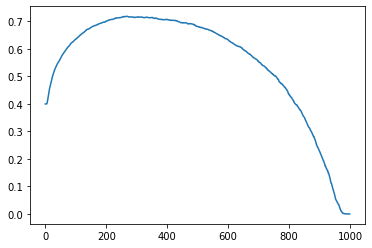

In [11]:
def f1_score_with_threshold(y_true, y_hat, thrshold=0.5):
    y_hat=y_hat>thrshold
    return f1_score(y_true, y_hat)

thrs=np.linspace(0,1, num=1000)

f1_curve=[f1_score_with_threshold (y_train,oof_probs, t) for t in thrs  ]
plt.plot(f1_curve)
max_idx=np.argmax(f1_curve)
max_ths=thrs[max_idx]
print(f"max_idx: {max_idx} max_ths: {max_ths} max: {f1_curve[max_idx]}",)

### Analyse OOF results

In [12]:
def  analyse_model(model,desc, raw_numer=10, plot=False):
    print(desc)
    fi=pd.DataFrame({'Feature':df_train.columns,'importance':model.feature_importance()})
    fi.sort_values('importance',ascending=False, inplace=True)

    if plot:
        ax=sns.barplot(y='Feature',x='importance',data=fi)
        plt.xticks(rotation=90)
    
    print(fi.head(raw_numer))
    return fi

In [13]:
fi=analyse_model(model, "Kfold")

Kfold
                    Feature  importance
235   geology_cat_3_nunique        1781
200                 1_sdoif         924
33                  9_slope         895
1118     diag_lr1_std_slope         800
1181               twi_mean         737
32                  8_slope         703
1145             slope_d2_1         637
1096           8_slope_rank         579
542   diag_lr1_std_lsfactor         575
1441            aspect_d3_4         516


In [14]:
score_f1=f1_score_with_threshold(y_train, oof_probs,max_ths )
print(f"OoO score_f1: {score_f1}")

OoO score_f1: 0.7190708634909948


### Plot Confusion Matrix

max_ths: 0.2682682682682683


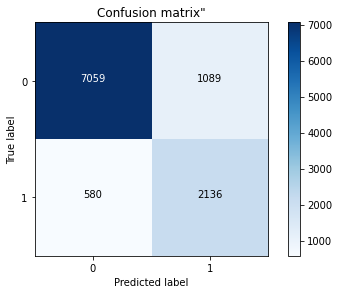

In [15]:
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix"',
                          cmap = plt.cm.Blues) :
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])) :
        plt.text(j, i, cm[i, j],
                 horizontalalignment = 'center',
                 color = 'white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(f"max_ths: {max_ths}")
oof_predictions_prob=np.where(oof_probs>max_ths,1,0)
cm = confusion_matrix(y_train, oof_predictions_prob)
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cm, classes = class_names)
plt.show()

# Predicting Test Results

In [16]:
all_test_prediction, all_test_prob, model_all_training=train_with_all_data_and_then_predict_test(df_train,y_train,df_test,num_iter=30000,
                                                                                                 seed=my_seed, f1_threshold=0.09)

Testing num_iter: 30000...
[3000]	training's binary_logloss: 0.0415614	training's f1: 0.941095
[6000]	training's binary_logloss: 0.0048037	training's f1: 1
[9000]	training's binary_logloss: 0.00056196	training's f1: 1
[12000]	training's binary_logloss: 5.96419e-05	training's f1: 1
[15000]	training's binary_logloss: 6.93132e-06	training's f1: 1
[18000]	training's binary_logloss: 3.62471e-06	training's f1: 1
[21000]	training's binary_logloss: 2.92653e-06	training's f1: 1
[24000]	training's binary_logloss: 2.67496e-06	training's f1: 1
[27000]	training's binary_logloss: 2.48621e-06	training's f1: 1
[30000]	training's binary_logloss: 2.37074e-06	training's f1: 1
predicting  ...


In [17]:
np.histogram(all_test_prediction, bins=2)

(array([3721, 1709]), array([0. , 0.5, 1. ]))

In [18]:
analyse_model(model_all_training, "All training")

All training
                    Feature  importance
235   geology_cat_3_nunique        7800
1118     diag_lr1_std_slope        5214
1441            aspect_d3_4        4769
542   diag_lr1_std_lsfactor        4312
33                  9_slope        4061
200                 1_sdoif        3904
1262       diag_lr1_std_twi        3334
1298               twi_d4_0        3277
1124     diag_rl0_std_slope        3251
551   diag_rl1_std_lsfactor        3234


,Feature,importance
235,geology_cat_3_nunique,7800
1118,diag_lr1_std_slope,5214
1441,aspect_d3_4,4769
542,diag_lr1_std_lsfactor,4312
33,9_slope,4061
...,...,...
888,procurv_d12_2,0
887,procurv_d12_1,0
886,procurv_d12_0,0
885,procurv_d11_4,0


### Preparing Submission file

In [19]:
def sub_files(file_name, test_result):    
    if max(test_result)>1 or min(test_result)<0 :
        print(f'invalid file : {file_name} due to boundary')
        return 
    if sum(test_result==0)==len(test):
        print(f'invalid file : {file_name} as all prediction is 0')
        return 
    
    if sum(test_result==1)==len(test):
        print(f'invalid file : {file_name} as all prediction is 1')
        return 
        
    df_sub_file = pd.DataFrame({'Sample_ID': test.Sample_ID, 'Label': test_result})    
    print(df_sub_file.head())
    # Create a csv file and upload to zindi 
    #sub_file_name=path+f'{file_name}_f1_score_{score_f1}.csv'
    sub_file_name=f'{file_name}_f1_score_{score_f1}.csv'
    print(f'Saving to {sub_file_name}')
    df_sub_file.to_csv(sub_file_name, index = False)    

In [20]:
sub_files('test_result',all_test_prediction)

   Sample_ID  Label
0      10865      0
1      10866      0
2      10867      0
3      10868      1
4      10869      1
Saving to test_result_f1_score_0.7190708634909948.csv
